# Alignment of hypothetical 7D NMR spectra using WNetAlign

In [ ]:
# !pip install pandas numpy matplotlib seaborn

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import os

In [2]:
from nmr.simulate import simulate_7d_shifts
from nmr.metrics import metrics_simulated_CM

In [3]:
FIG_PATH = "Figures"

In [4]:
DATA_PATH = "7D/NMR_7D_without_nan"

## Histogram

In [5]:
DATA_FOLDER = "7D/NMR_7D"
ids = [int(i) for i in open(DATA_FOLDER+"/IDs.txt", "r").read().split()]

all_7d = {}

for i in ids:
    df = pd.read_csv(f"{DATA_FOLDER}/test_{i}.csv", index_col=0)
    all_7d[i] = df

for i in ids:
    df = pd.read_csv(f"{DATA_FOLDER}/train_{i}.csv", index_col=0)
    for i in ids:
        df_prot = df[df['protein'] == i]
        if df_prot.shape[0] != 0: 
            all_7d[i] = pd.concat([all_7d[i], df_prot])

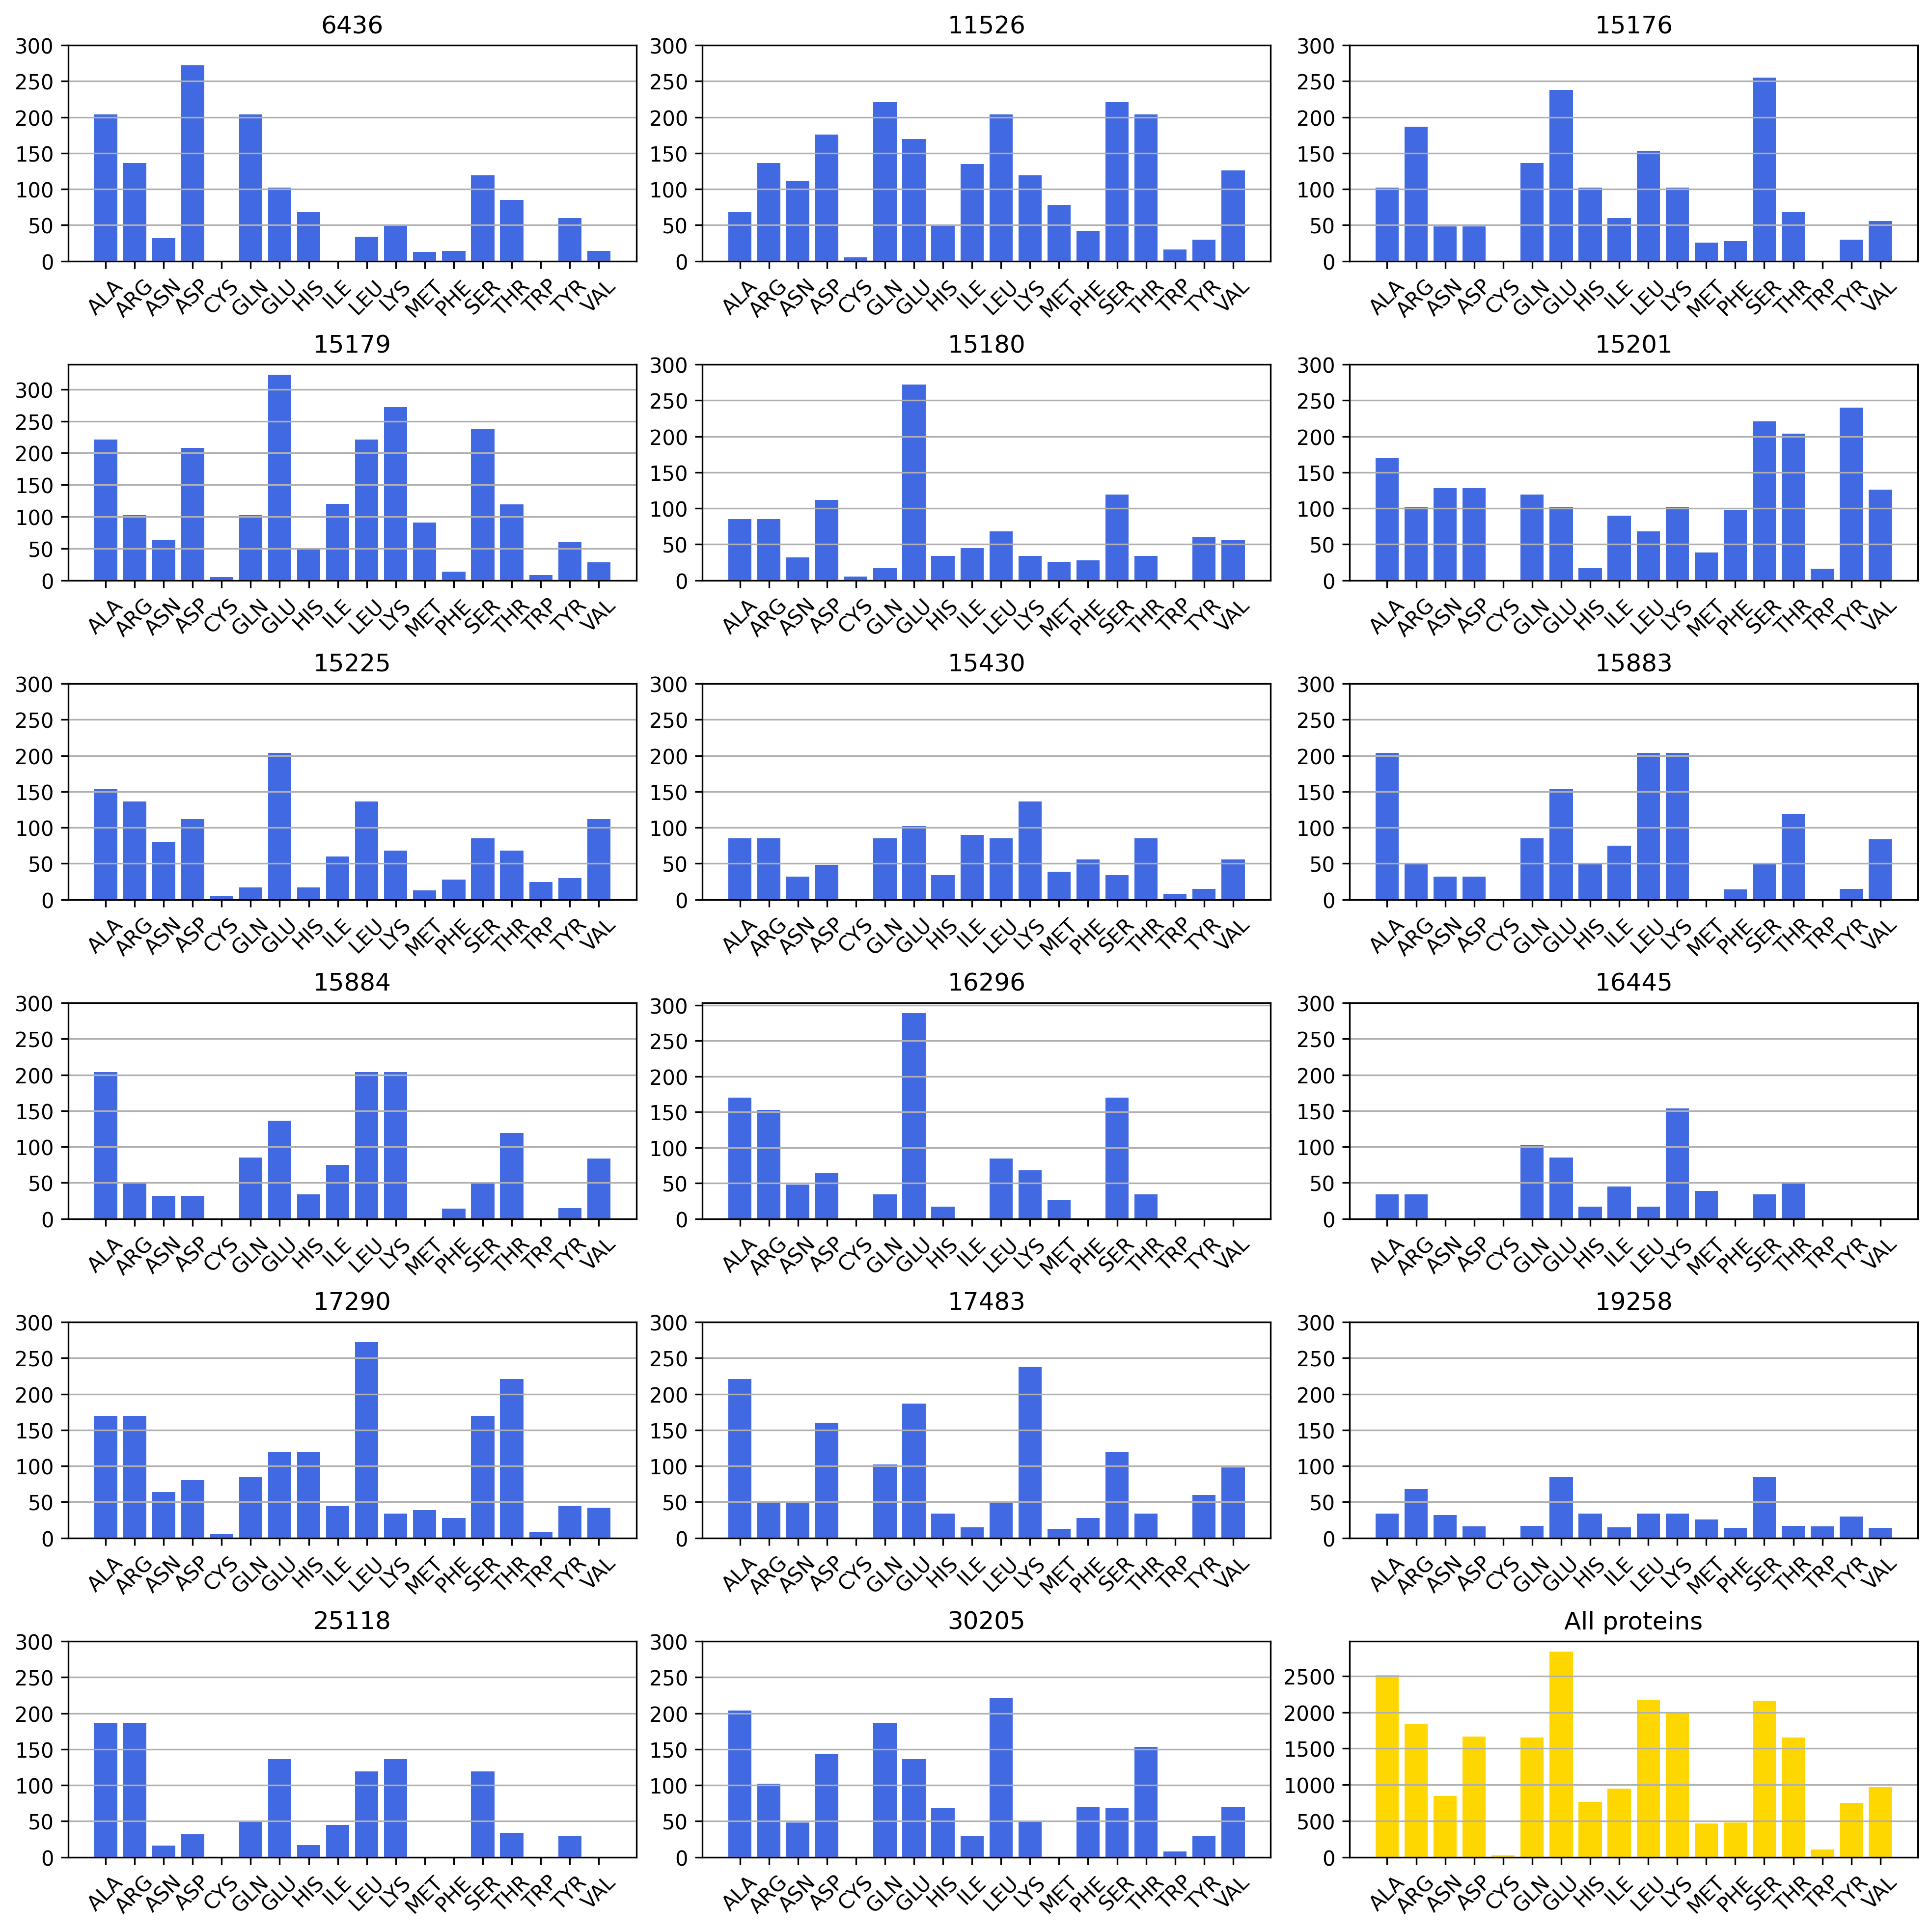

In [6]:
AA = ['ALA', 'ARG', 'ASN', 'ASP', 'CYS', 'GLN', 'GLU', 'HIS', 'ILE', 'LEU', 'LYS', 'MET', 'PHE', 'SER', 'THR', 'TRP', 'TYR', 'VAL']
AA_by_protein = {p: [all_7d[p][all_7d[p]['amino'] == aa].shape[0] for aa in AA] for p in all_7d} 

x = np.arange(len(AA))
n = 3
fig, ax = plt.subplots(18//n, n, figsize=(13, 13), layout='constrained', squeeze=True, dpi=300)

for i, (protein, aa_counts) in enumerate(AA_by_protein.items()):
    ax[i//n, i%n].bar(x, aa_counts, color="royalblue")
    ax[i//n, i%n].set_title(f"{protein}")
    ax[i//n, i%n].set_xticks(x, AA, rotation=45)
    # ax[i//n, i%n].set_ylim(0, 300)
    ax[i//n, i%n].set_yticks([i*50 for i in range(7)])
    ax[i//n, i%n].grid(axis='y')

# # summed up
ax[(i+1)//n, (i+1)%n].bar(x, np.array(list(AA_by_protein.values())).sum(axis=0), color="gold")
ax[(i+1)//n, (i+1)%n].set_title(f"All proteins")
ax[(i+1)//n, (i+1)%n].set_xticks(x, AA, rotation=45)
# ax[(i+1)//n, (i+1)%n].set_ylim(0, 2300)
ax[(i+1)//n, (i+1)%n].set_yticks([i*500 for i in range(6)])
ax[(i+1)//n, (i+1)%n].grid(axis='y')


plt.savefig(f"{FIG_PATH}/NMR_7D_test+train_hist.png")
plt.show()

## Extended metrics

In [7]:
AA = ['ALA', 'ARG', 'ASN', 'ASP', 'CYS', 'GLN', 'GLU', 'HIS', 'ILE', 'LEU', 'LYS', 'MET', 'PHE', 'SER', 'THR', 'TRP', 'TYR', 'VAL']
lims_aa = {aa: (-0.015, 0.015) for aa in AA}

nuclei = ['HN', 'N', 'CO', 'CA', 'CB', 'HA', 'HB']
lims_nucl = {nucl: (0.015, 0.025) for nucl in nuclei}

print(lims_aa)
print(lims_nucl)
print()

{'ALA': (-0.015, 0.015), 'ARG': (-0.015, 0.015), 'ASN': (-0.015, 0.015), 'ASP': (-0.015, 0.015), 'CYS': (-0.015, 0.015), 'GLN': (-0.015, 0.015), 'GLU': (-0.015, 0.015), 'HIS': (-0.015, 0.015), 'ILE': (-0.015, 0.015), 'LEU': (-0.015, 0.015), 'LYS': (-0.015, 0.015), 'MET': (-0.015, 0.015), 'PHE': (-0.015, 0.015), 'SER': (-0.015, 0.015), 'THR': (-0.015, 0.015), 'TRP': (-0.015, 0.015), 'TYR': (-0.015, 0.015), 'VAL': (-0.015, 0.015)}
{'HN': (0.015, 0.025), 'N': (0.015, 0.025), 'CO': (0.015, 0.025), 'CA': (0.015, 0.025), 'CB': (0.015, 0.025), 'HA': (0.015, 0.025), 'HB': (0.015, 0.025)}



In [8]:
simulated_spectra, spectra, aa_by_spectrum, shifts = simulate_7d_shifts(data_path=DATA_PATH,
                                                               lims_nucl=lims_nucl, 
                                                               lims_aa=lims_aa,
                                                               dim = 7,
                                                               shift_independently = False,
                                                               OUT_FOLDER = "7D/simulated_spectra",
                                                               # OUT_FOLDER = None,
                                                               seed = 0,
                                                               default_rng = False,
                                                              )

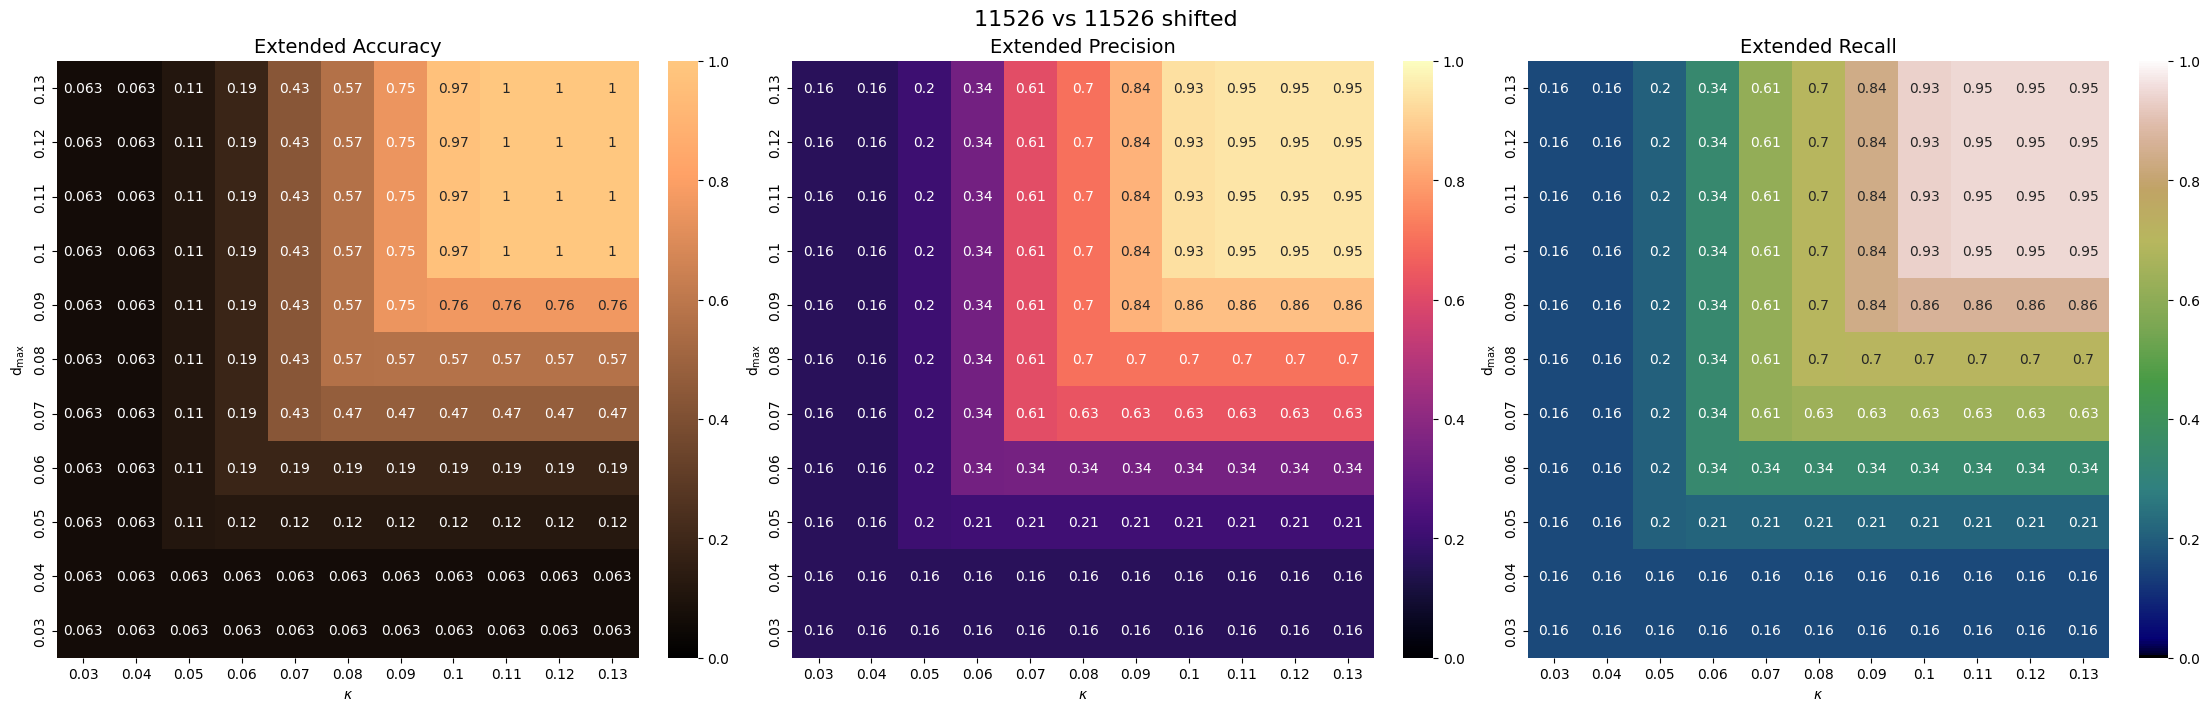

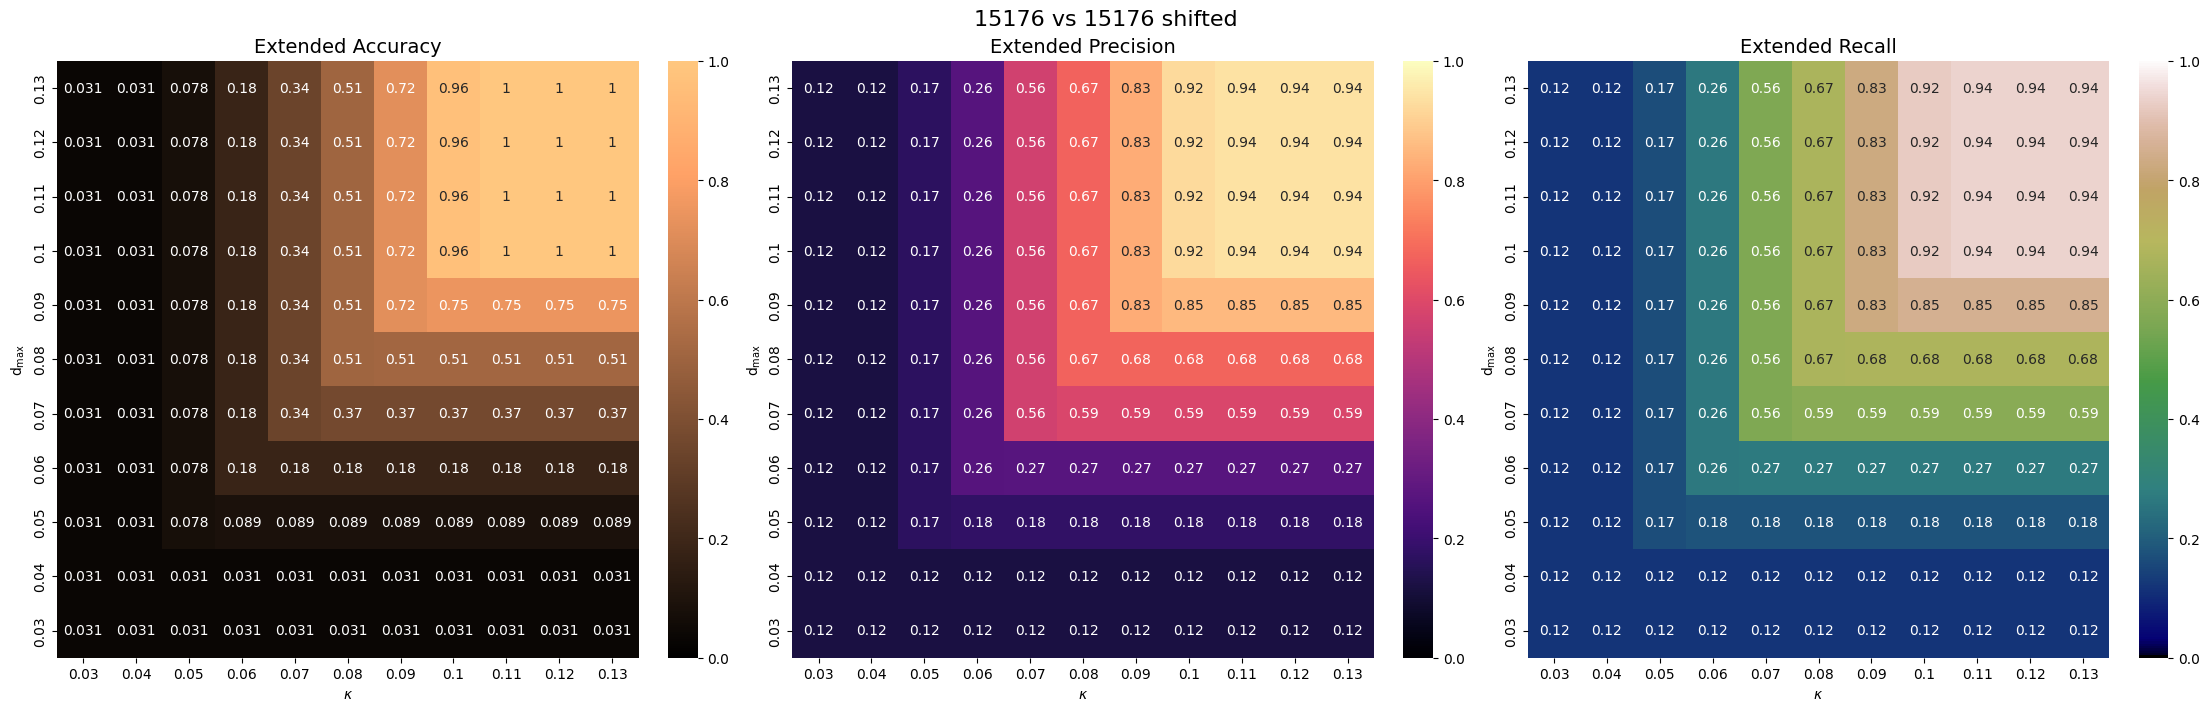

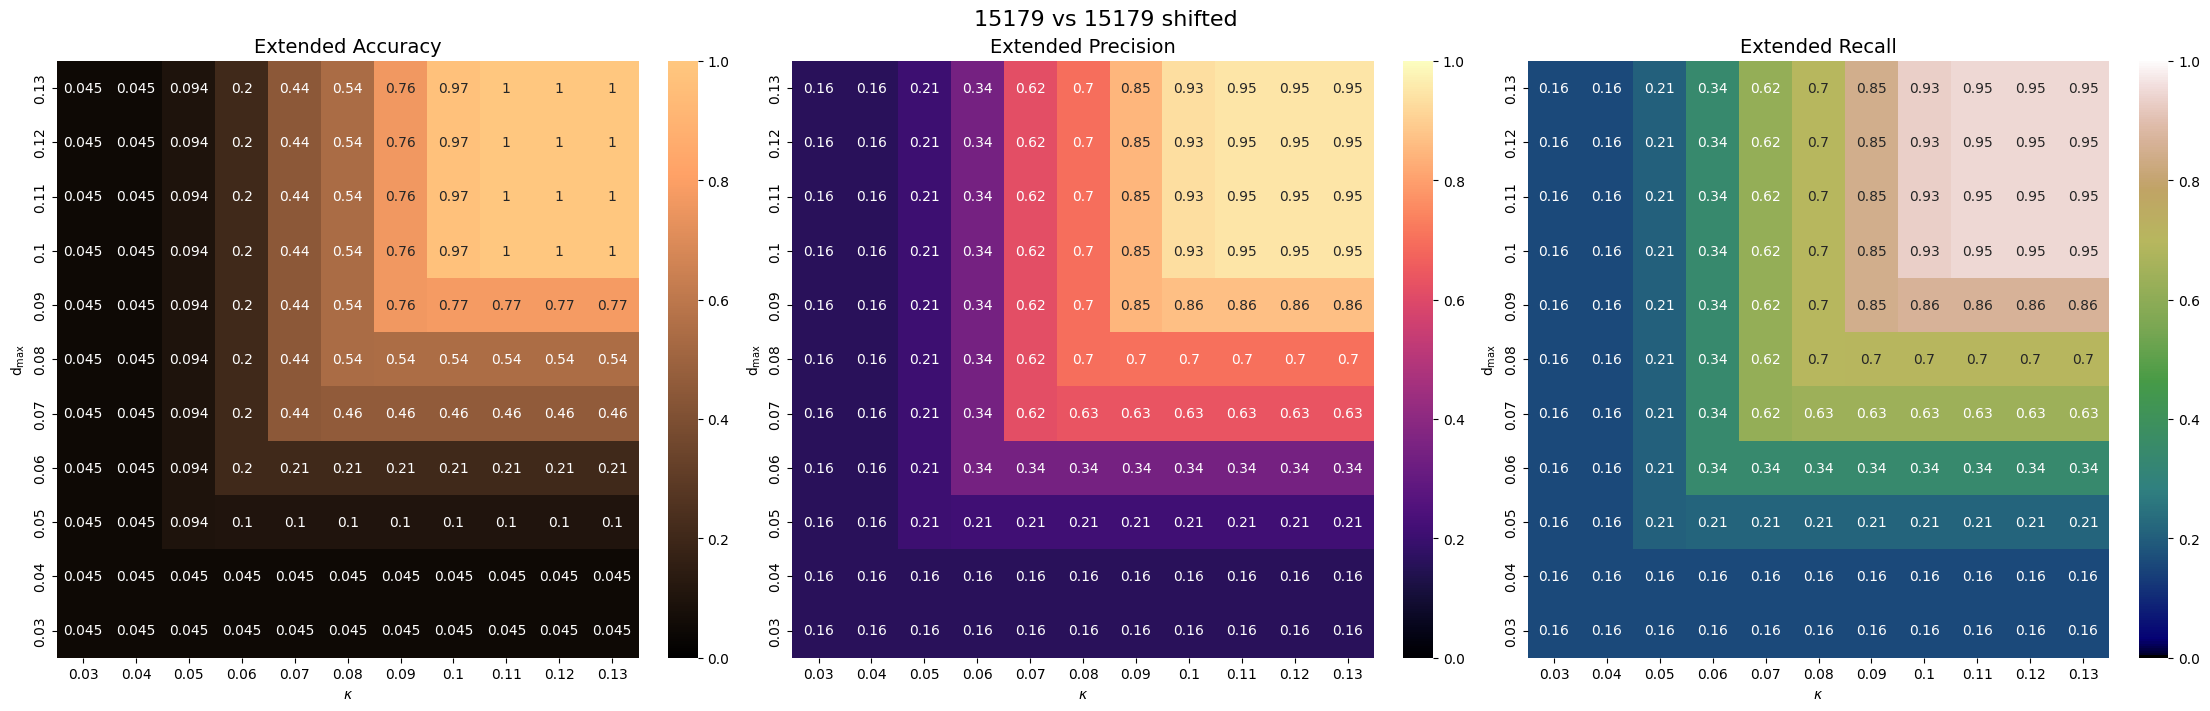

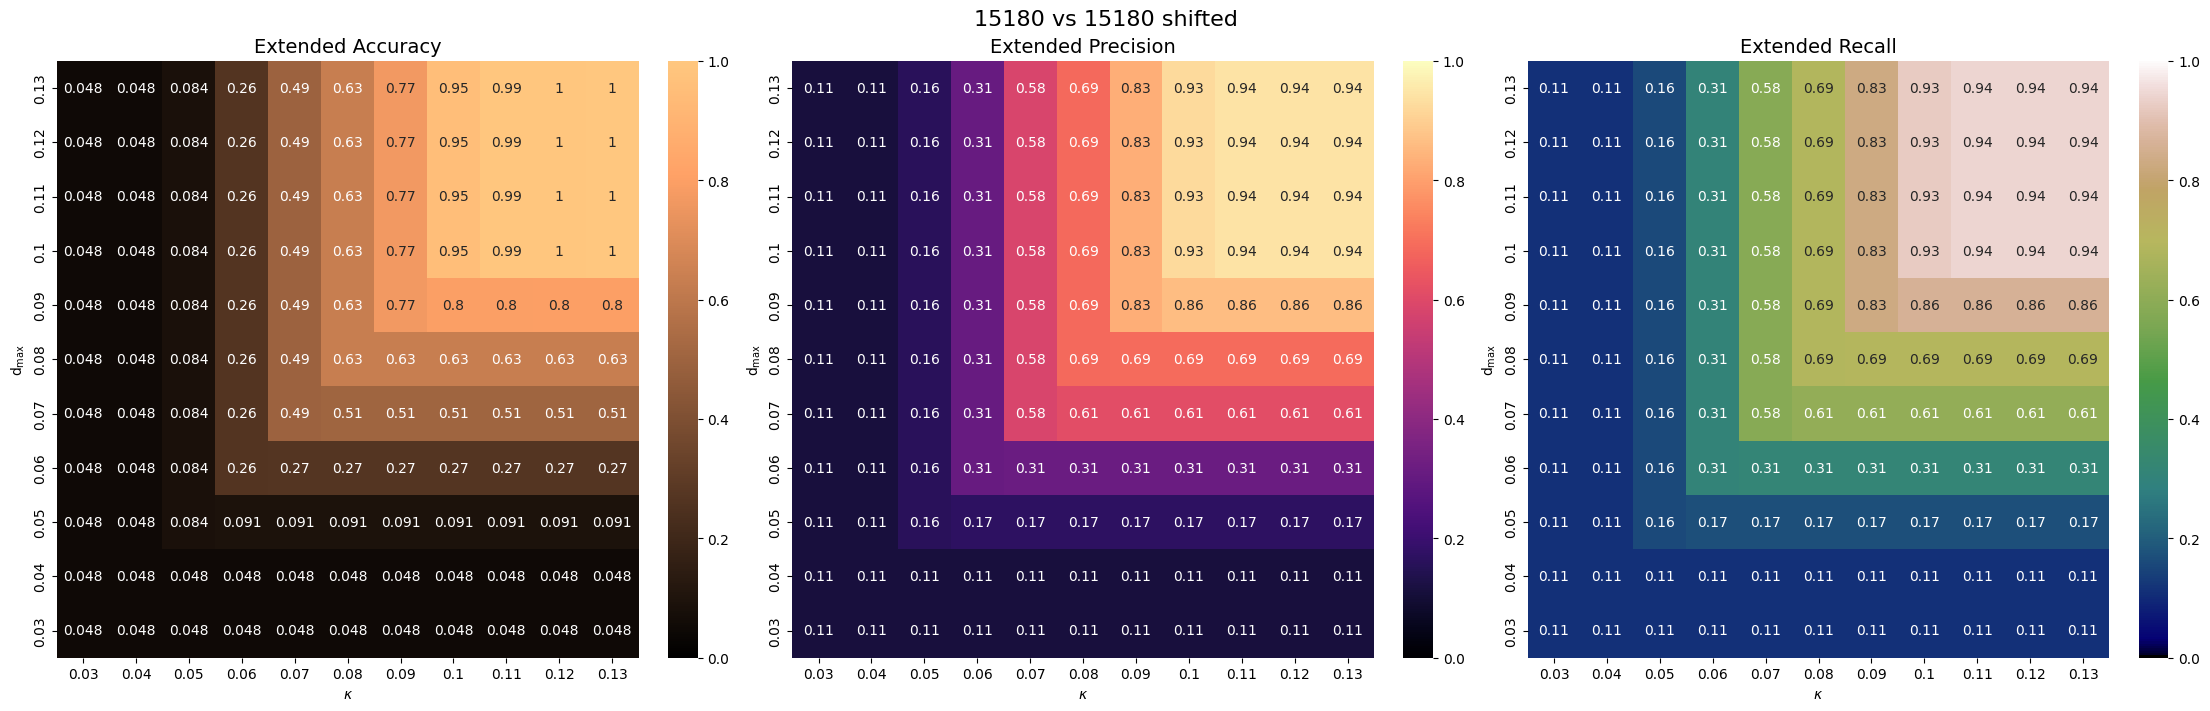

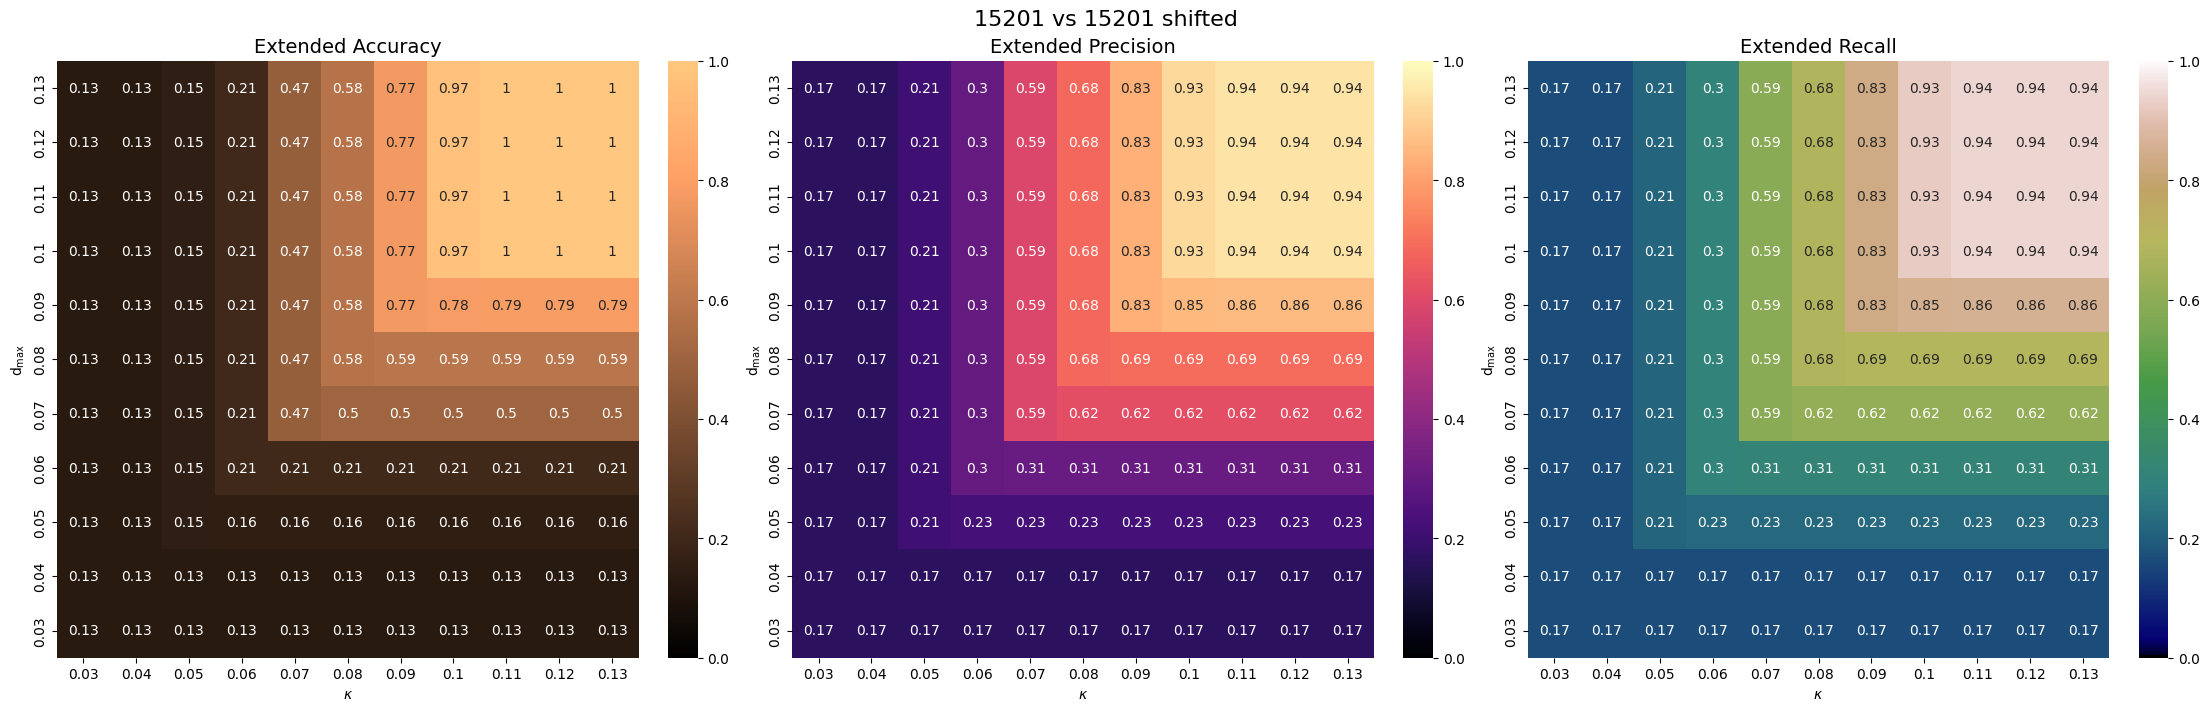

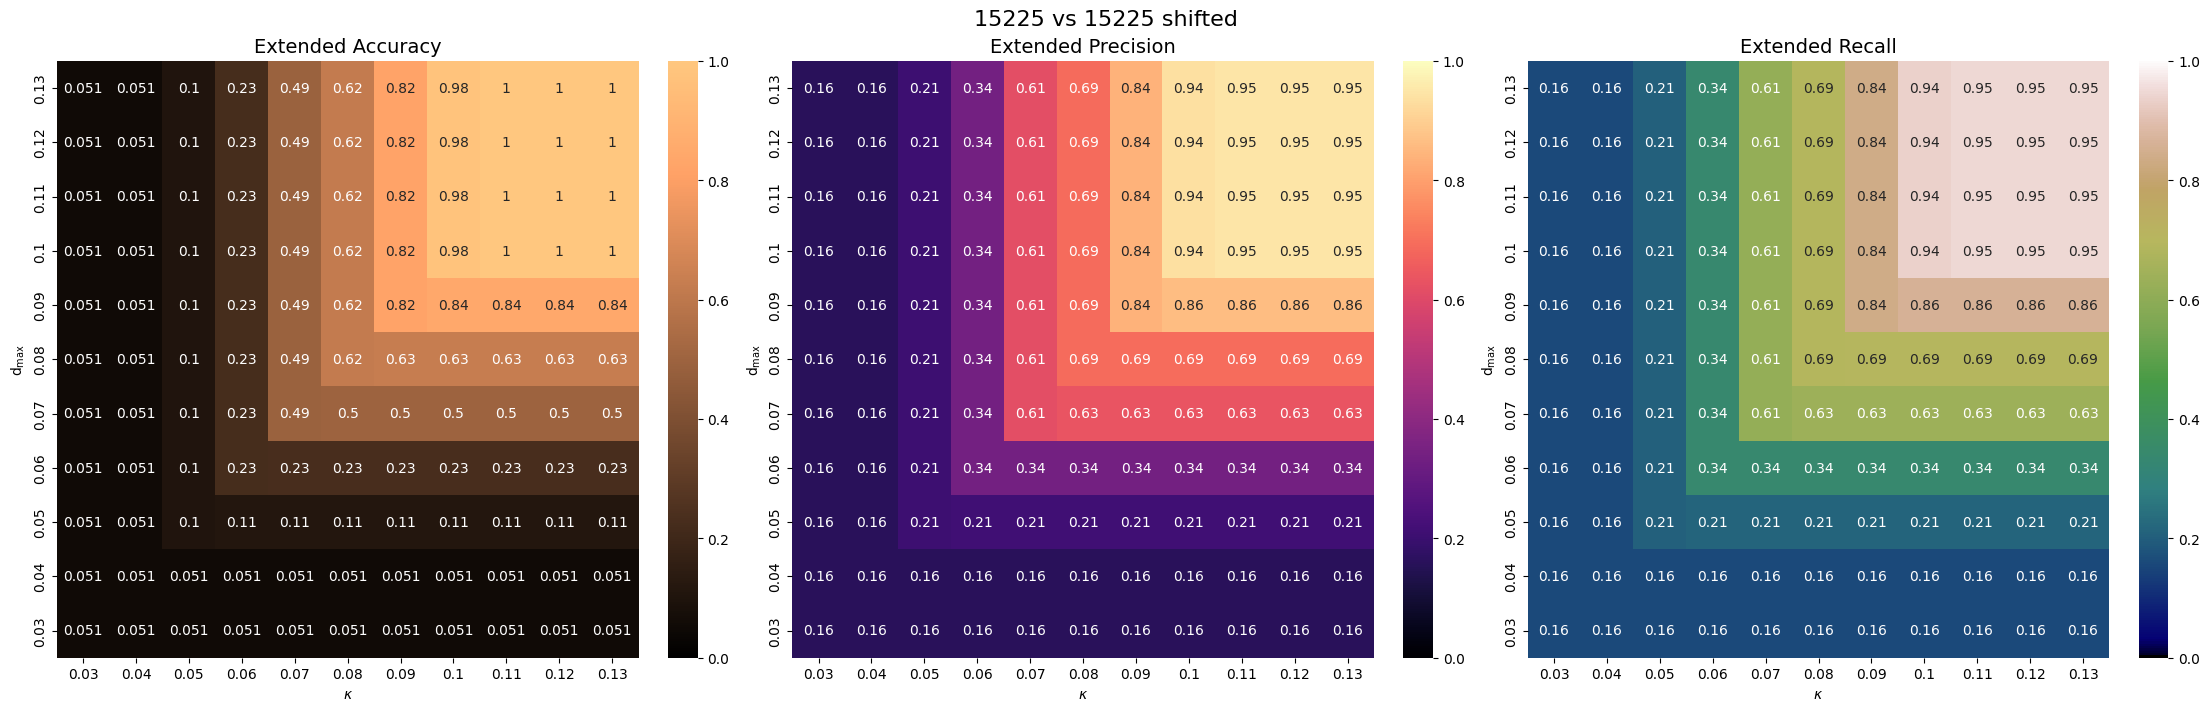

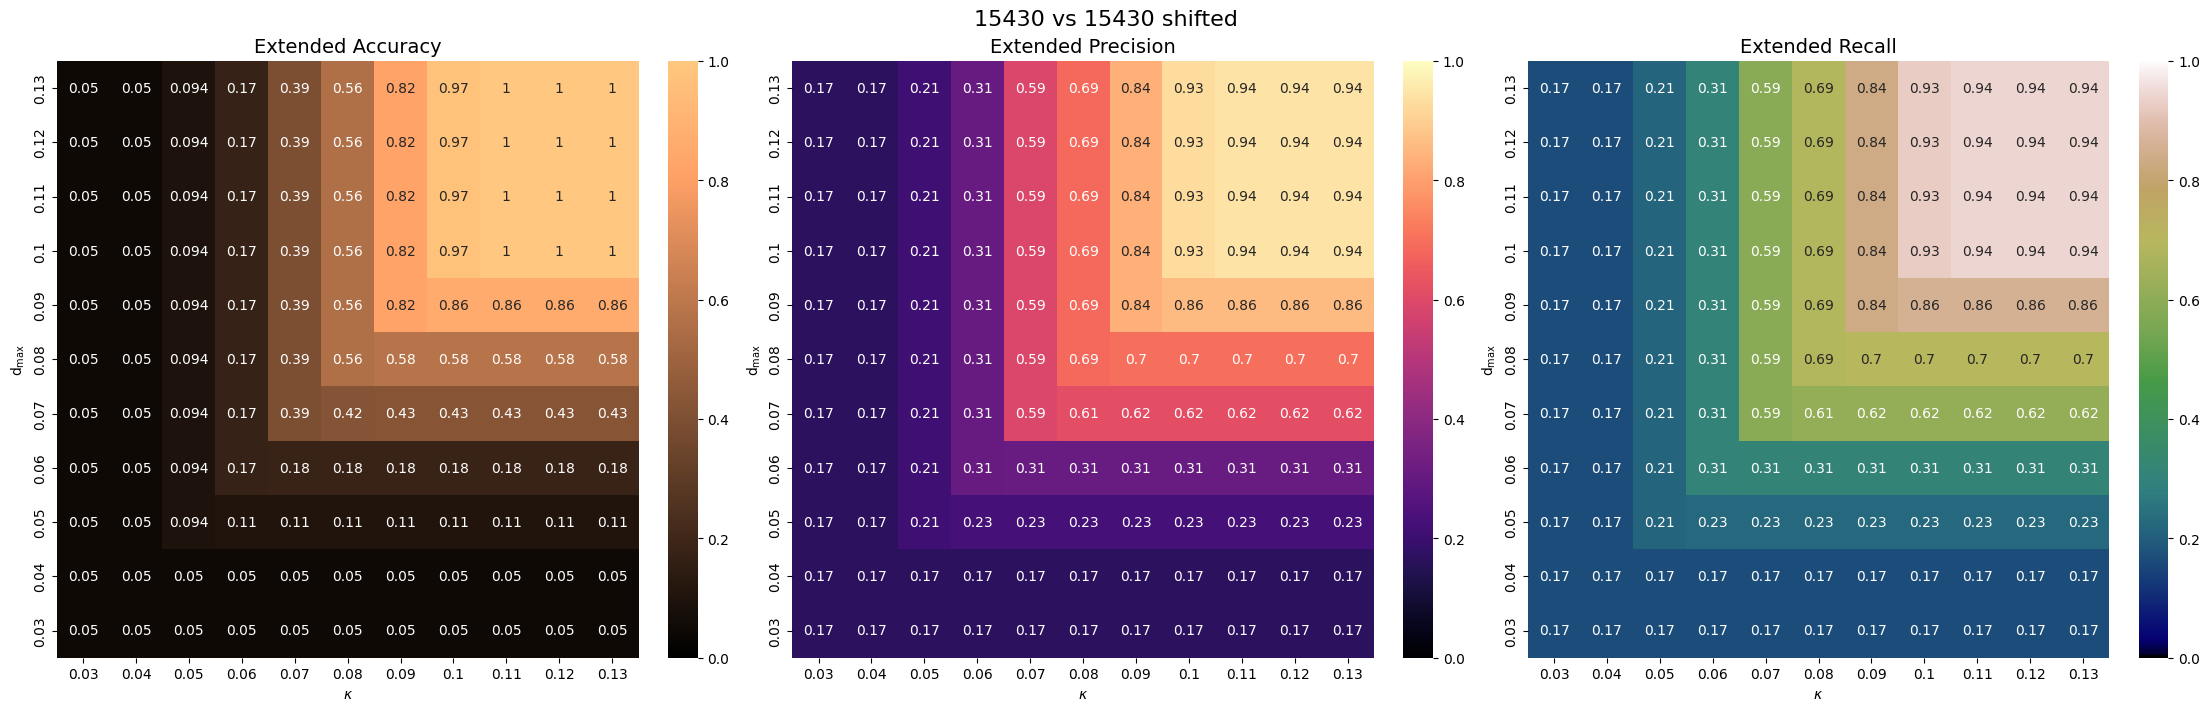

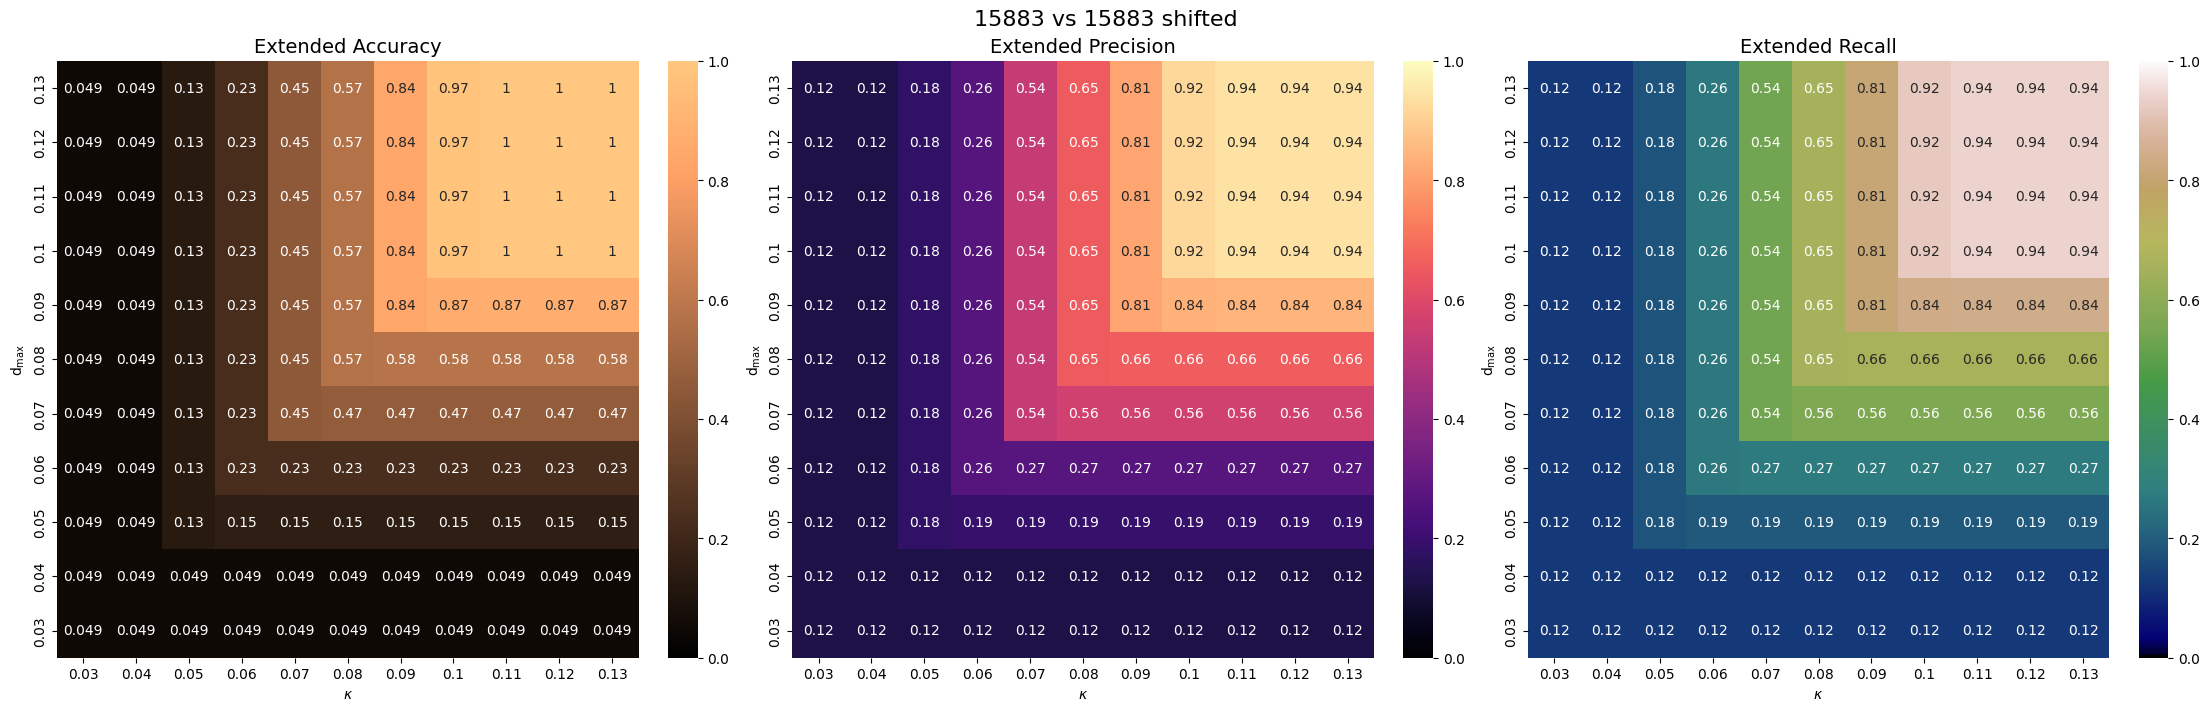

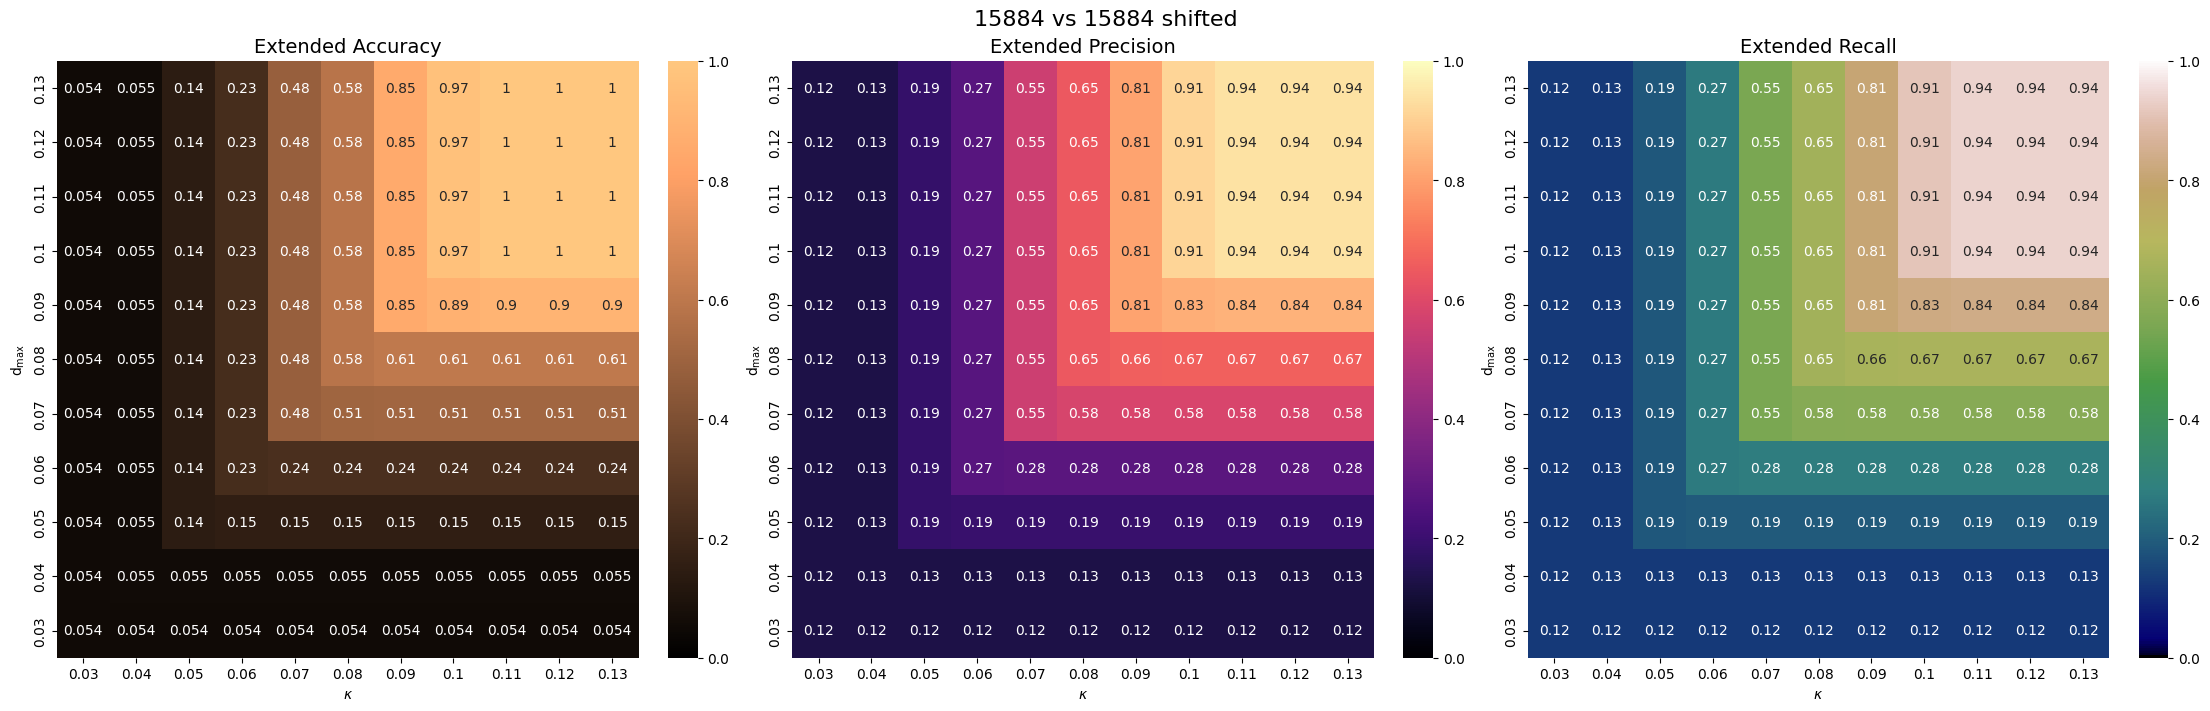

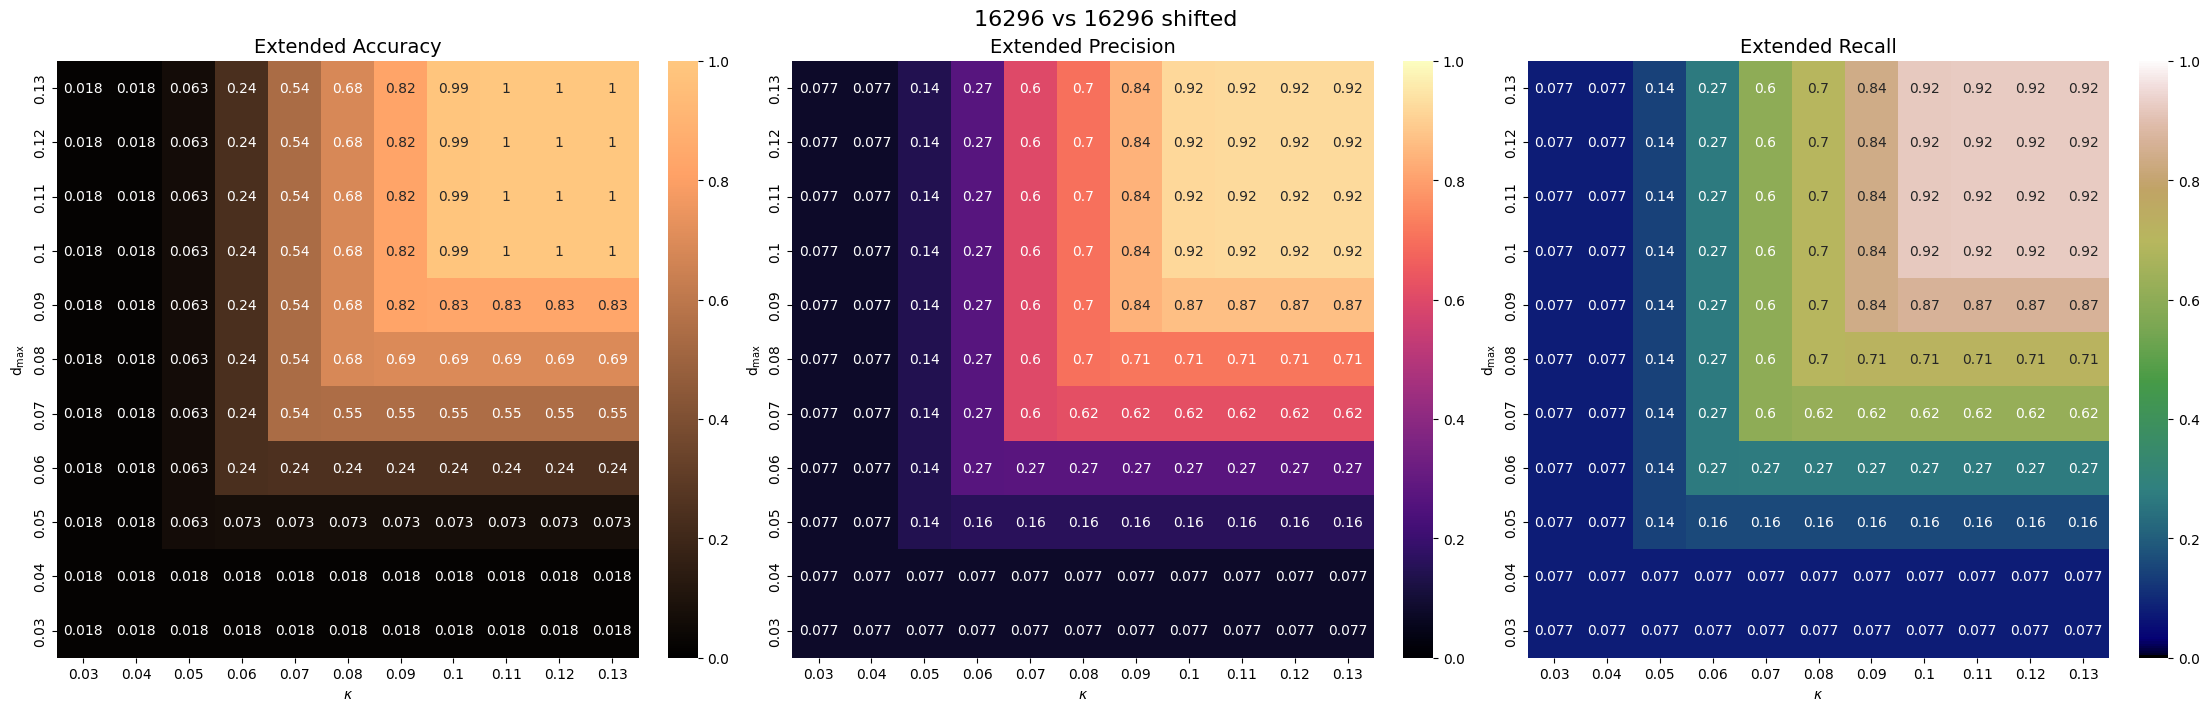

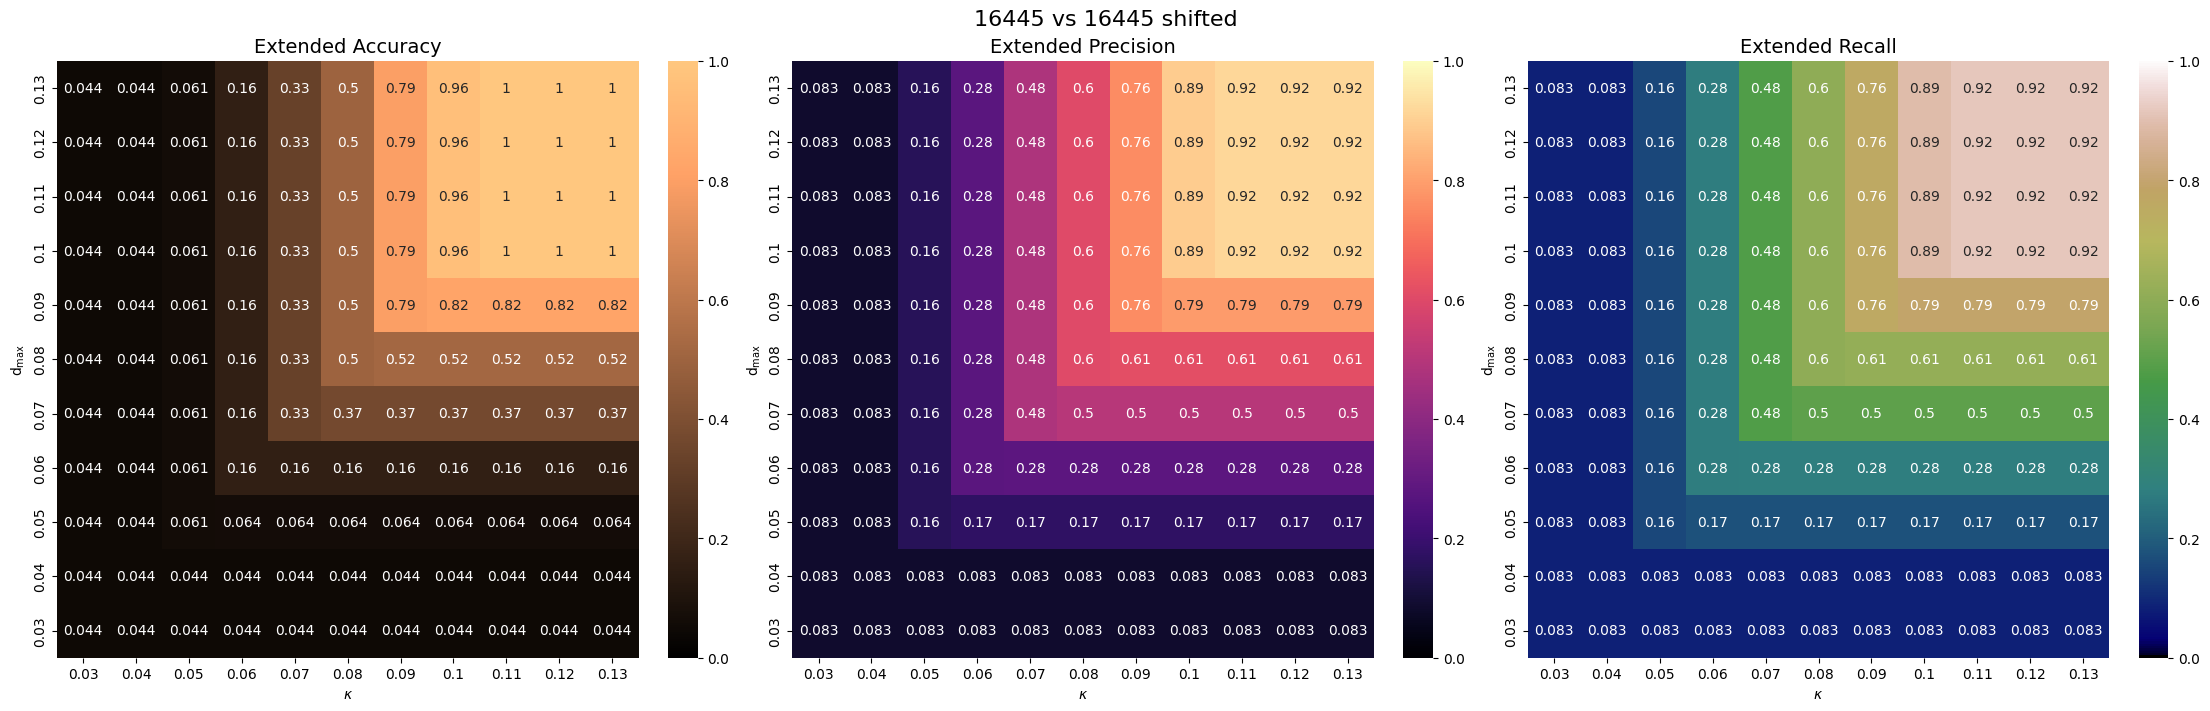

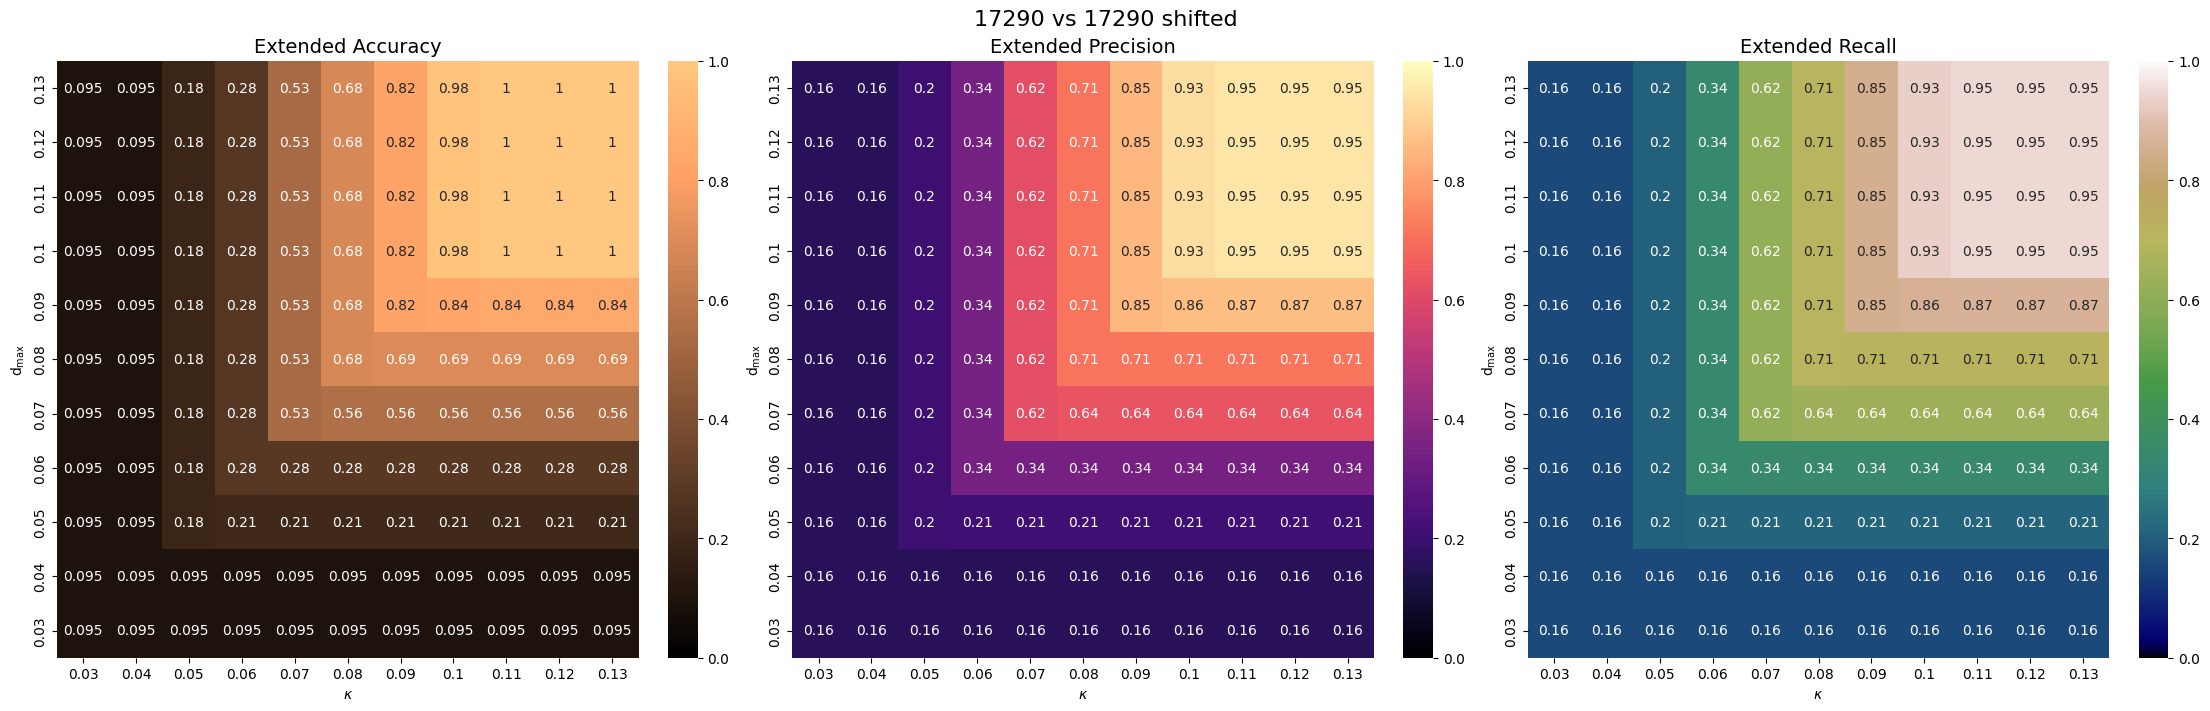

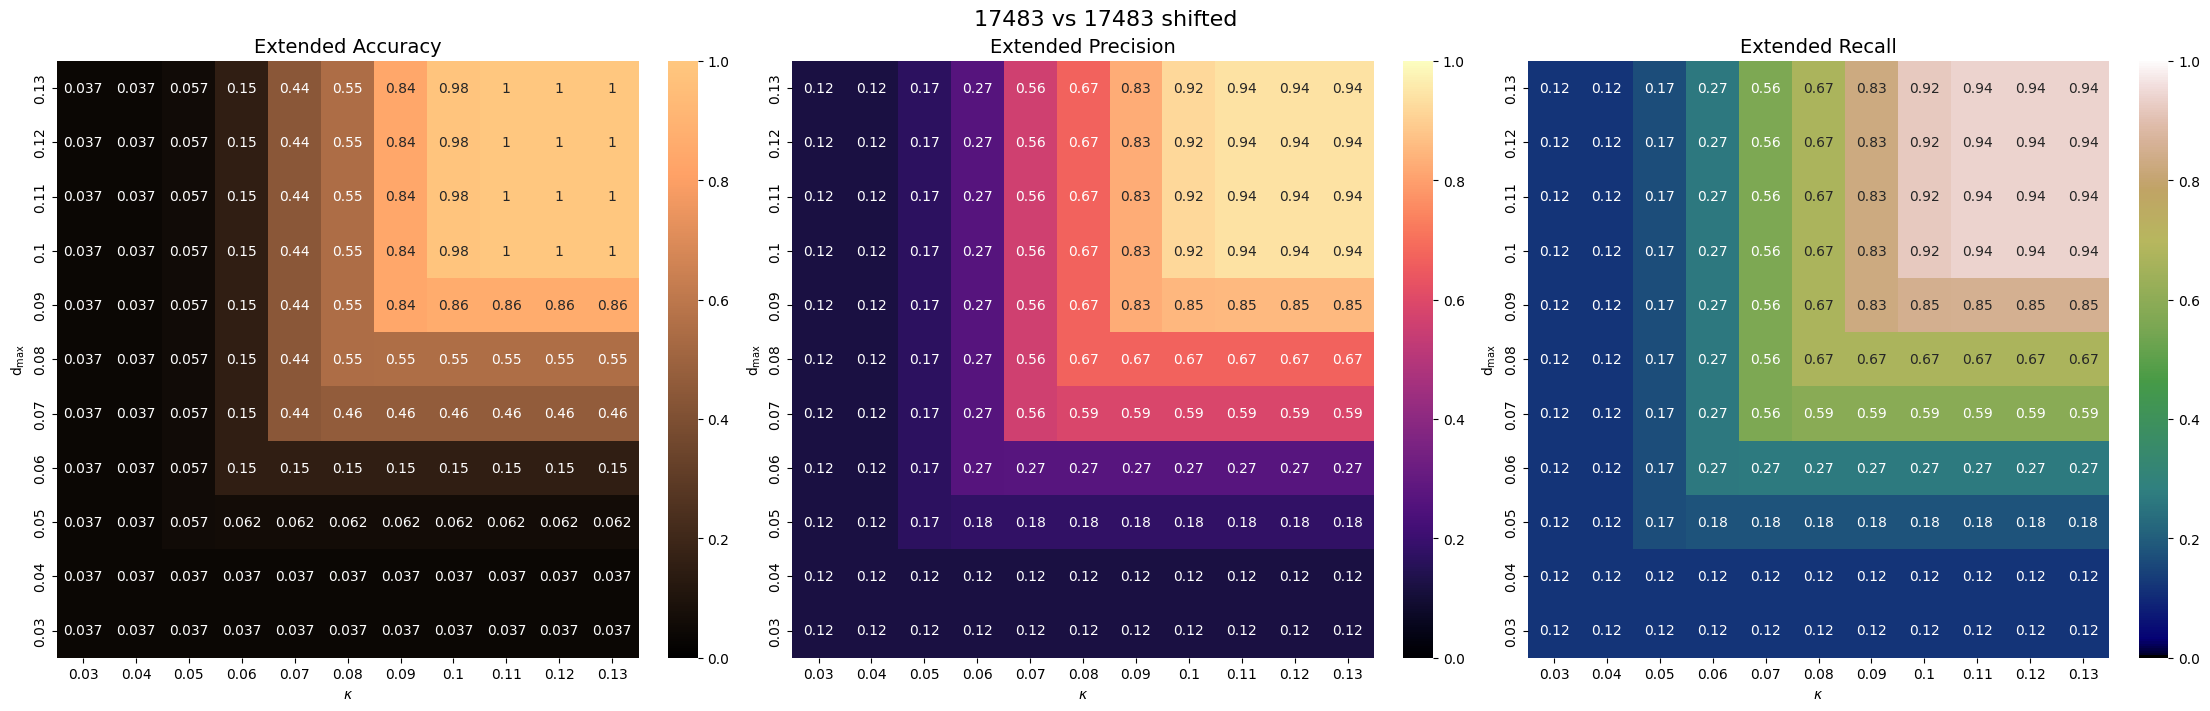

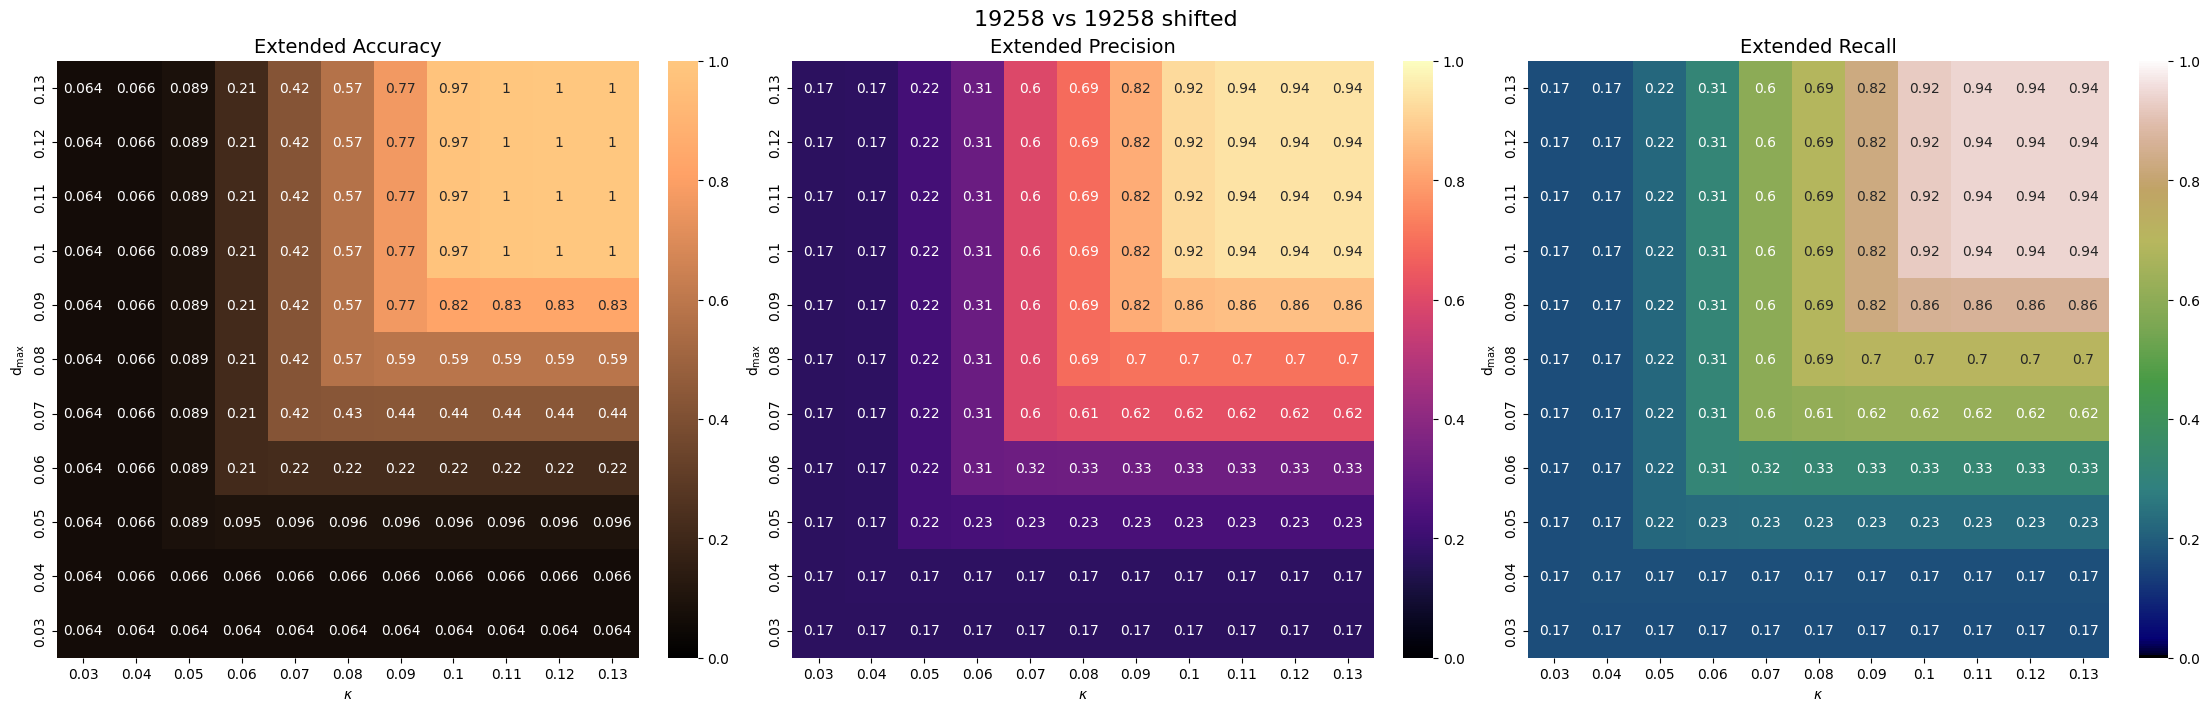

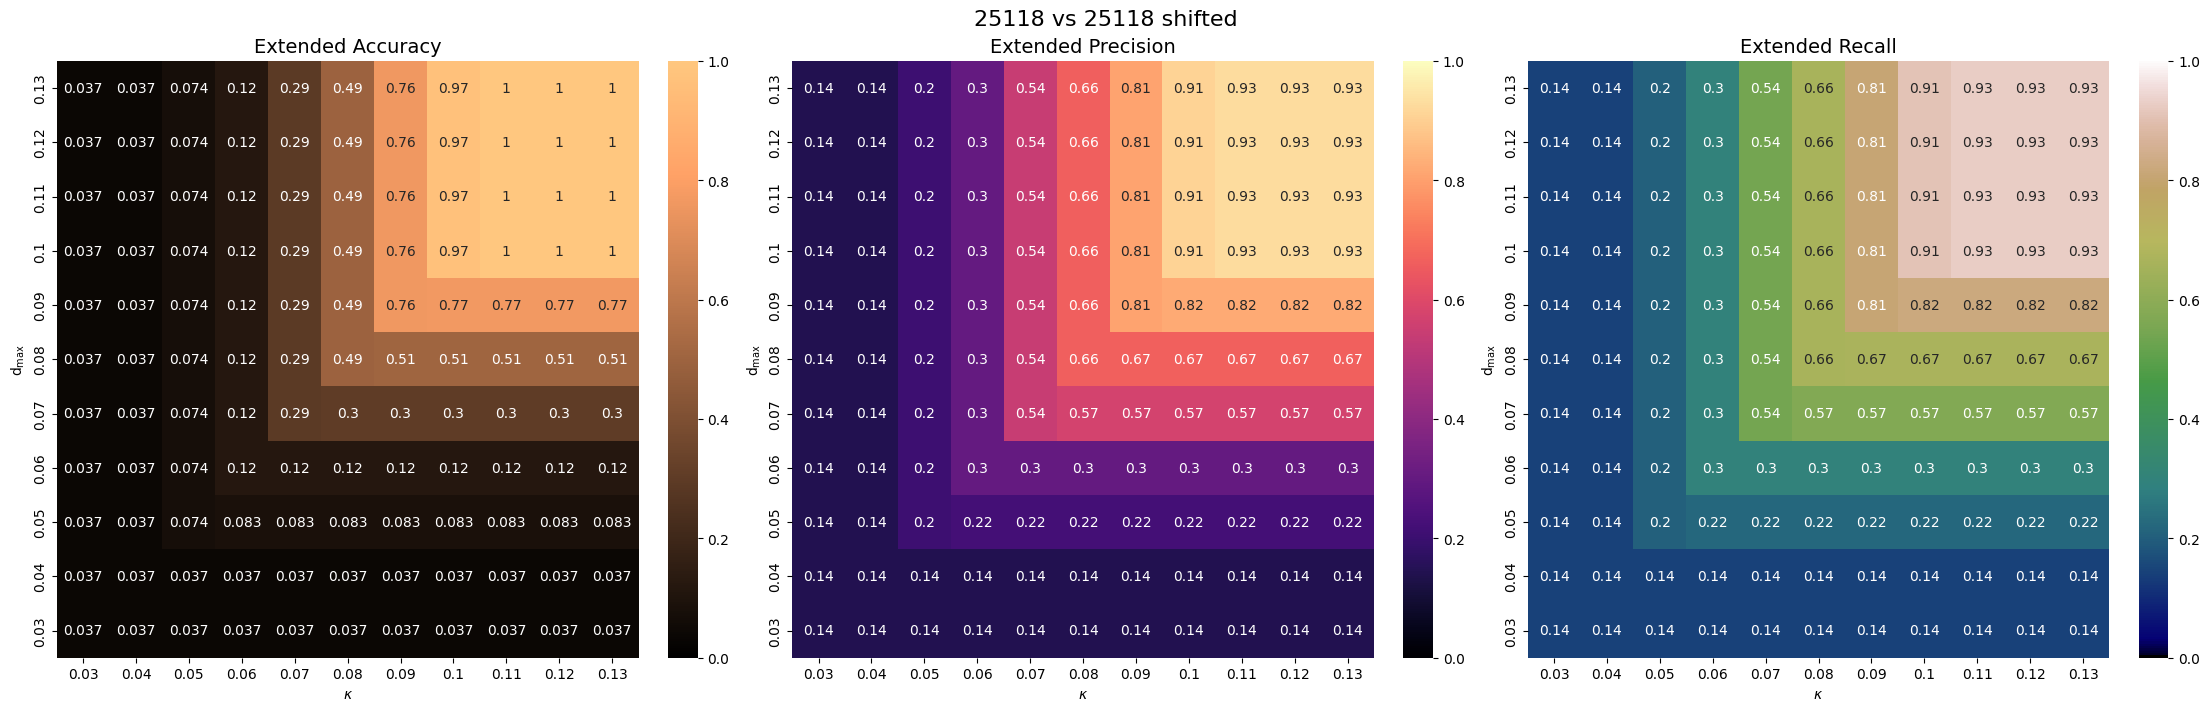

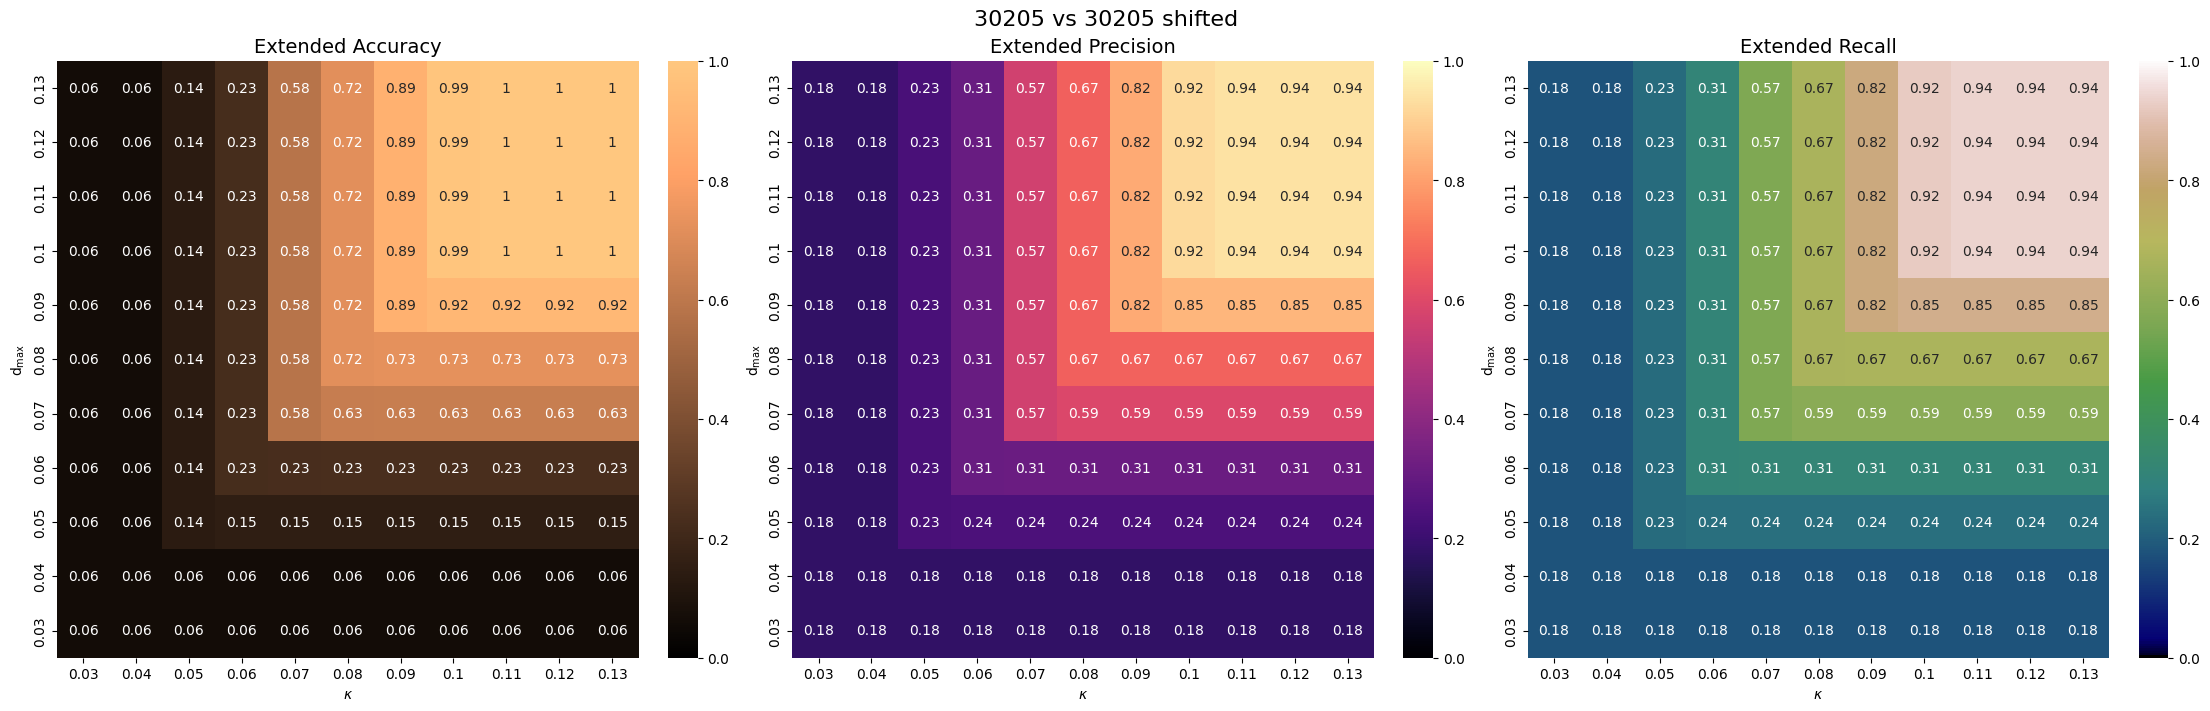

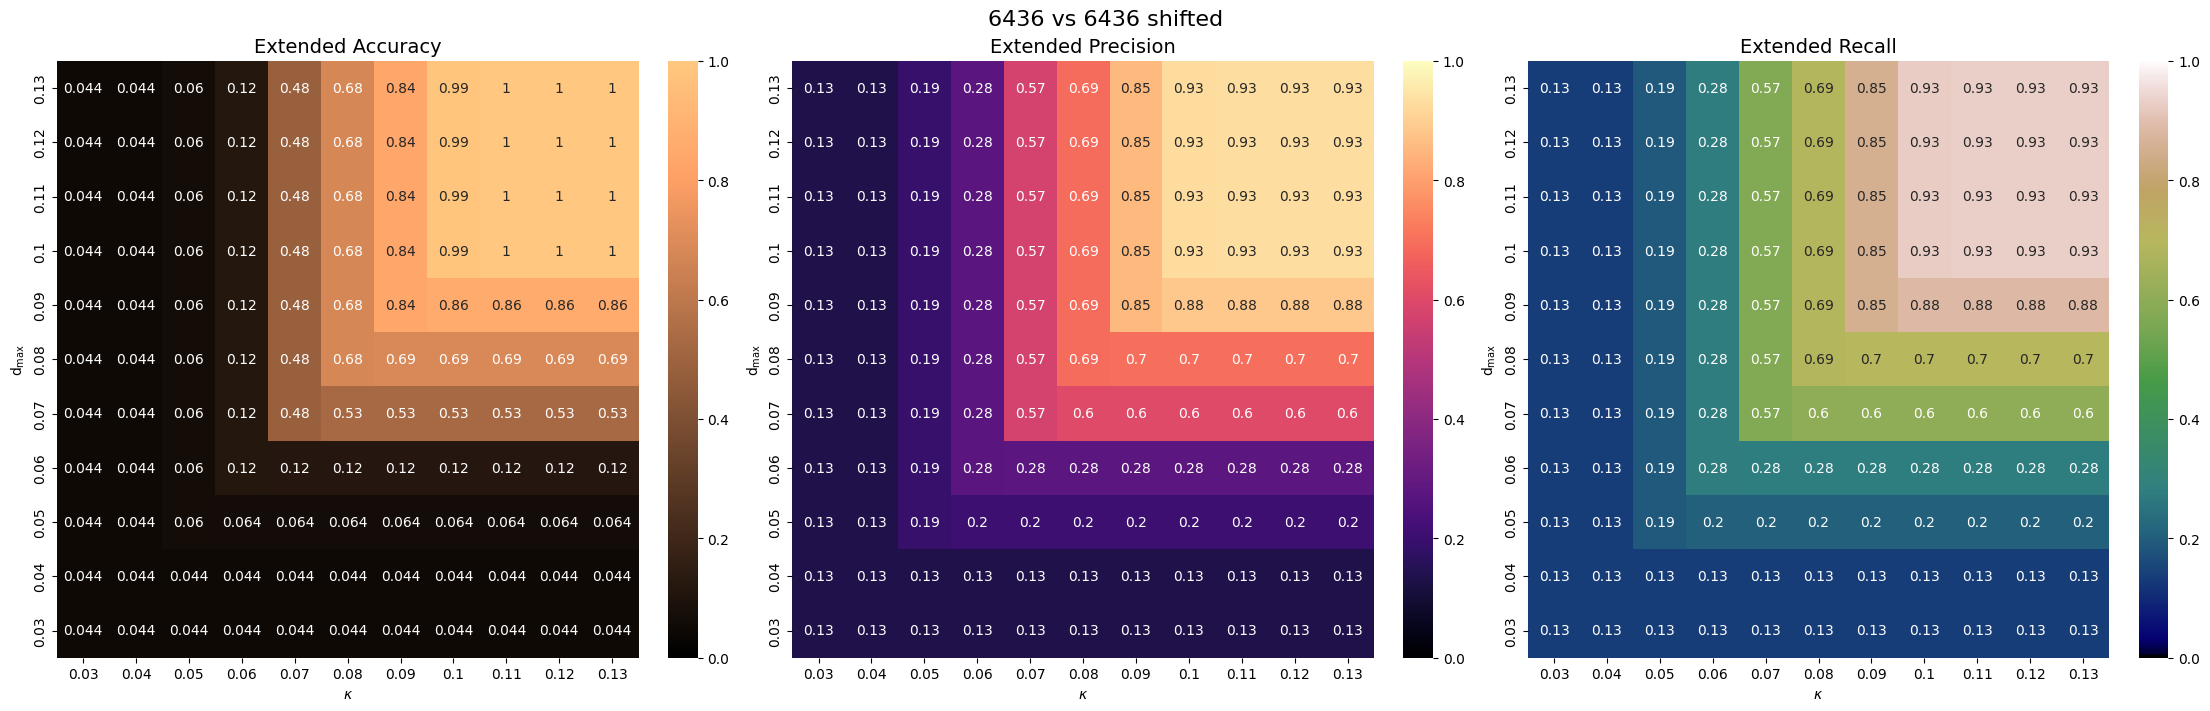

In [9]:
max_distances = [0.01*i for i in range(13, 2, -1)]
trash_costs = [0.01*i for i in range(3, 14)]

cmap_names = ['copper', 'magma', 'gist_earth', 'magma', 'gist_earth']

for s1, s2, aa in zip(spectra, simulated_spectra, aa_by_spectrum):
    metrics_cm_extended = metrics_simulated_CM([s1, s2], 
                                               max_distances=max_distances, 
                                               trash_costs=trash_costs, 
                                               classes=aa, 
                                               scale_nucl={}, 
                                               nuclei=['HN', 'N', 'CO', 'CA', 'CB', 'HA', 'HB'], 
                                               extended=True, 
                                               warn=False,
                                                 )

    metric_to_cmap = dict(zip(metrics_cm_extended.keys(), cmap_names))
    
    protein = metrics_cm_extended['Accuracy'].keys()
    
    metrics_to_plot = {k: v for k, v in metrics_cm_extended.items() if k in ['Accuracy', 'Precision (macro)', 'Recall (macro)']}
    metrics_by_protein = {r: {'Accuracy': None, 'Precision (macro)': None, 'Recall (macro)': None} for r in protein}
    
    for metric in metrics_to_plot:
        for name in metrics_to_plot[metric]:
            metrics_by_protein[name][metric] = metrics_to_plot[metric][name]
    
    cbar_lim = {'Accuracy': (0, 1), 'Precision (macro)': (0, 1), 'Recall (macro)': (0, 1)}
    k = 3
    cbar=True
    
    for protein in metrics_by_protein:
        vmax = max([m.max().max() for m in metrics_by_protein[protein].values()])
        vmin = min([m.min().min() for m in metrics_by_protein[protein].values()])
    
        fig, ax = plt.subplots(1, k, figsize=(7*3+1, 7), constrained_layout=True, squeeze=False)
        for i, metric in enumerate(metrics_by_protein[protein]):
            # cbar = True if i%k == k-1 else False
            sns.heatmap(metrics_by_protein[protein][metric], 
                        ax=ax[i//k, i%k], 
                        vmin=cbar_lim[metric][0], 
                        vmax=cbar_lim[metric][1], 
                        cmap=sns.color_palette(metric_to_cmap[metric], as_cmap=True), 
                        cbar=cbar, 
                        annot=True)
            ax[i//k, i%k].set(xlabel="$\\kappa$", ylabel="d${_\\text{max}}$")
            ax[i//k, i%k].set_title(label=f"Extended {metric.split(" ")[0]}", fontsize=14)
        plt.suptitle(f"{protein}", fontsize=16)
        dirpath = f"{FIG_PATH}/Extended_metrics_7D"
        if not os.path.exists(dirpath):
            os.makedirs(dirpath)
        plt.savefig(f"{dirpath}/Extended_metrics_7D_{"_".join(protein.split())}.png")
        plt.show()